In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(0,1))

In [4]:
endpoint = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym=BTC&tsym=USD&limit=500'
api_key = '2b967442562fe24c326388ed0d91d7dd9dab4fbbbcbf929bdc71e5c5fe56f9b3'
res = requests.get(endpoint + '&api_key={your_api_key}')

In [5]:
hist = pd.DataFrame(json.loads(res.content)['Data']['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
high_col = 'high'
low_col = 'low'
open_col = 'open'
volumefrom_col = 'volumefrom'
volumeto_col = 'volumeto'
close_col = 'close'
hist.drop("conversionType", axis=1, inplace=True)
hist.drop("conversionSymbol", axis=1, inplace=True)

In [6]:
hist.head(20)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-11-22,18757.55,17635.18,18704.06,43464.62,7.967680e+08,18430.59
2020-11-23,18761.66,18010.51,18430.59,48994.17,9.025185e+08,18385.74
2020-11-24,19419.49,18117.78,18385.74,74142.30,1.403473e+09,19157.16
2020-11-25,19488.81,18519.89,19157.16,59989.48,1.141495e+09,18725.76
2020-11-26,18907.31,16270.37,18725.76,129609.34,2.220673e+09,17175.86
2020-11-27,17479.12,16462.87,17175.86,61052.47,1.034427e+09,17155.00
2020-11-28,17893.95,16895.00,17155.00,34697.03,6.052849e+08,17739.90
2020-11-29,18347.24,17543.55,17739.90,27161.16,4.896800e+08,18199.23
2020-11-30,19850.23,18199.03,18199.23,77985.30,1.493788e+09,19686.87


In [8]:
def train_test_split(df, test_size):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [9]:
train_data, test_data= train_test_split(hist, 0.2) #train,test,val - 0.6,0.2,0.2

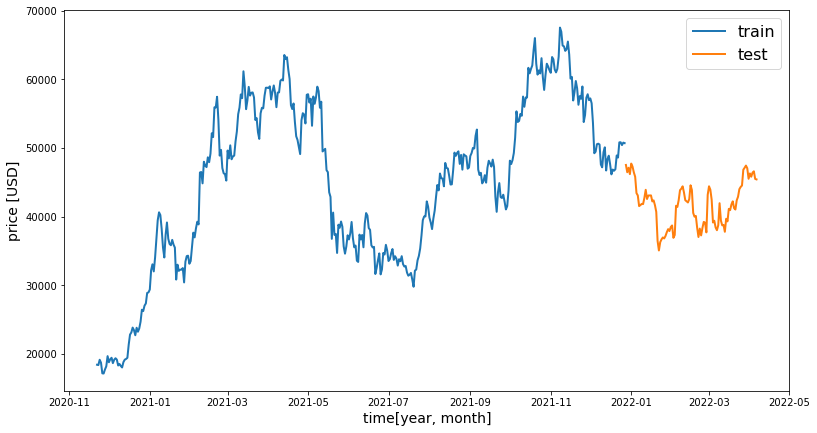

In [10]:
def line_plot(line1, line2, label1='train', label2='test',title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_xlabel('time[year, month]', fontsize=14)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train_data[close_col], test_data[close_col], 'train', 'test', title='')


In [11]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

In [12]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if  zero_base:
            tmp = normalise_zero_base(tmp)
            #tmp = scaler.fit_transform(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def extract_window_data_for_prediction(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len + 1):
        tmp = df[idx: (idx + window_len)].copy()
        if  zero_base:
            tmp = normalise_zero_base(tmp)
            #tmp = scaler.fit_transform(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [13]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    Y_train = train_data[target_col][window_len:].values
    Y_test = test_data[target_col][window_len:].values
    if zero_base:
        Y_train = Y_train / train_data[target_col][:-window_len].values - 1
        Y_test = Y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, Y_train, Y_test

In [14]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [15]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [16]:
train_high, test_high, X_train_high, X_test_high, Y_train_high, Y_test_high = prepare_data(
    hist, high_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
train_low, test_low, X_train_low, X_test_low, Y_train_low, Y_test_low = prepare_data(
    hist, low_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
train_open, test_open, X_train_open, X_test_open, Y_train_open, Y_test_open = prepare_data(
    hist, open_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
train_volumefrom, test_volumefrom, X_train_volumefrom, X_test_volumefrom, Y_train_volumefrom, Y_test_volumefrom = prepare_data(
    hist, volumefrom_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
train_volumeto, test_volumeto, X_train_volumeto, X_test_volumeto, Y_train_volumeto, Y_test_volumeto = prepare_data(
    hist, volumeto_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
train_close, test_close, X_train_close, X_test_close, Y_train_close, Y_test_close = prepare_data(
    hist, close_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [17]:
model_high= build_lstm_model(
    X_train_high, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model_low = build_lstm_model(
    X_train_low, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model_open = build_lstm_model(
    X_train_open, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model_volumefrom = build_lstm_model(
    X_train_volumefrom, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model_volumeto = build_lstm_model(
    X_train_volumeto, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
model_close = build_lstm_model(
    X_train_close, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

In [18]:
history_high = model_high.fit(
    X_train_high, Y_train_high, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
history_low = model_low.fit(
    X_train_low, Y_train_low, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
history_open = model_open.fit(
    X_train_open, Y_train_open, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
history_volumefrom = model_volumefrom.fit(
    X_train_volumefrom, Y_train_volumefrom, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
history_volumeto = model_volumeto.fit(
    X_train_volumeto, Y_train_volumeto, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
history_close = model_close.fit(
    X_train_close, Y_train_close, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 4ms/step - loss: 0.0074
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0038
Epoch 3/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 4/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0031
Epoch 5/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0025
Epoch 6/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0026
Epoch 7/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 8/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0024
Epoch 9/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 10/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0021
Epoch 11/20
13/13 [==============================] - 0s 5ms/step - loss: 0.0020
Epoch 12/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0022
Epoch 13/20
13/13 [==============================

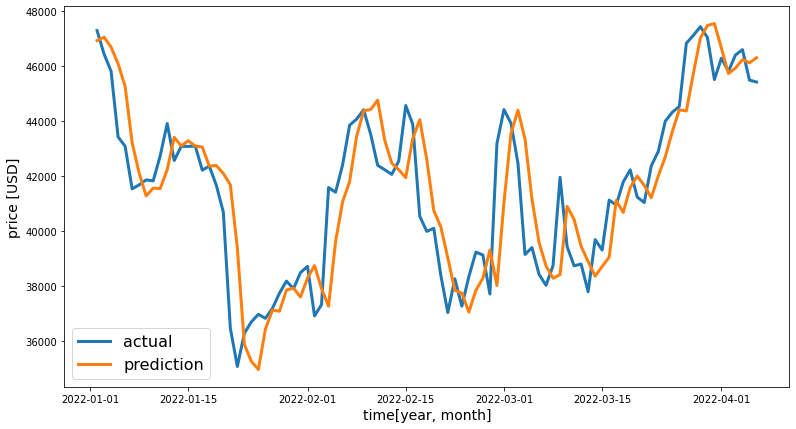

In [19]:
#test close price model
preds = model_close.predict(X_test_close).squeeze()
mean_absolute_error(preds, Y_test_close)
targets = test_close[close_col][window_len:]
preds = test_close[close_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

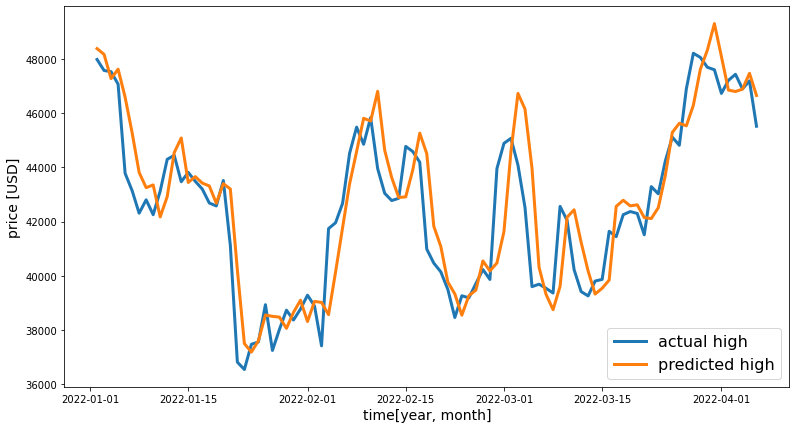

In [20]:
#test model_high
preds = model_high.predict(X_test_high).squeeze()
targets = test_high[high_col][window_len:]
preds = test_high[high_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual high', 'predicted high', lw=3)

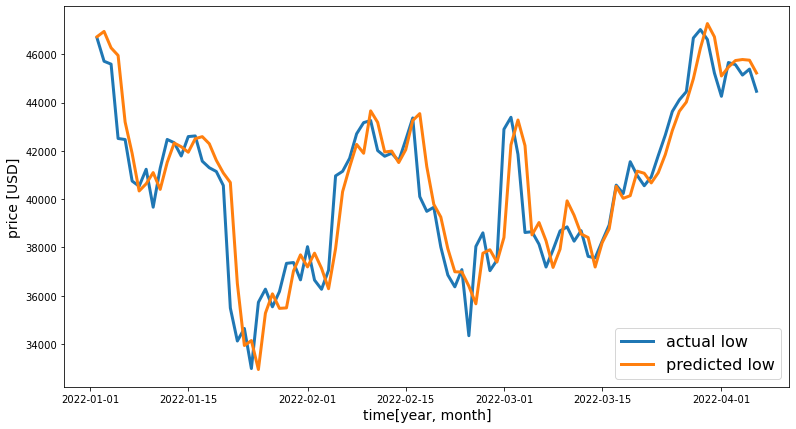

In [21]:
#test model_low
preds = model_low.predict(X_test_low).squeeze()
targets = test_low[low_col][window_len:]
preds = test_low[low_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual low', 'predicted low', lw=3)

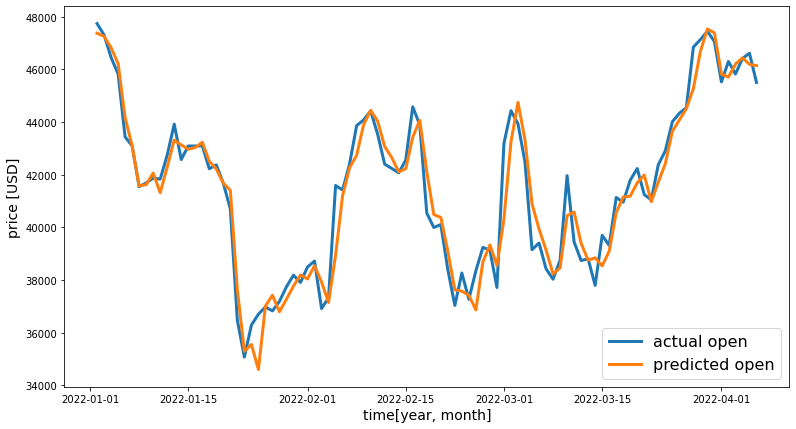

In [22]:
#test model_open
preds = model_open.predict(X_test_open).squeeze()
targets = test_open[open_col][window_len:]
preds = test_open[open_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual open', 'predicted open', lw=3)

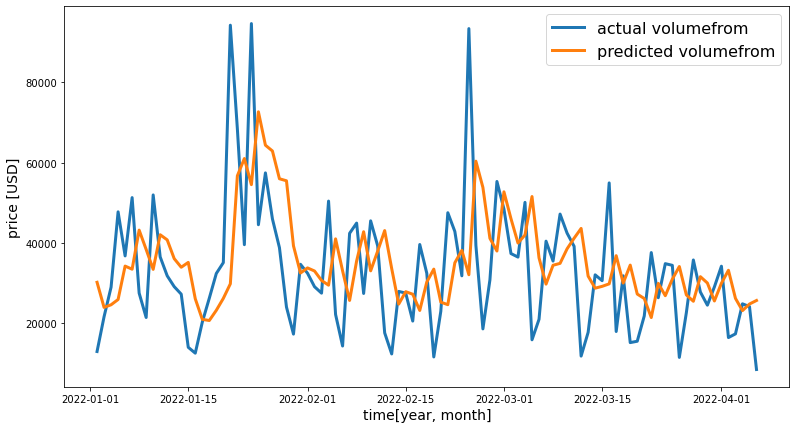

In [23]:
#test model_volumefrom
preds = model_volumefrom.predict(X_test_volumefrom).squeeze()
targets = test_volumefrom[volumefrom_col][window_len:]
preds = test_volumefrom[volumefrom_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual volumefrom', 'predicted volumefrom', lw=3)

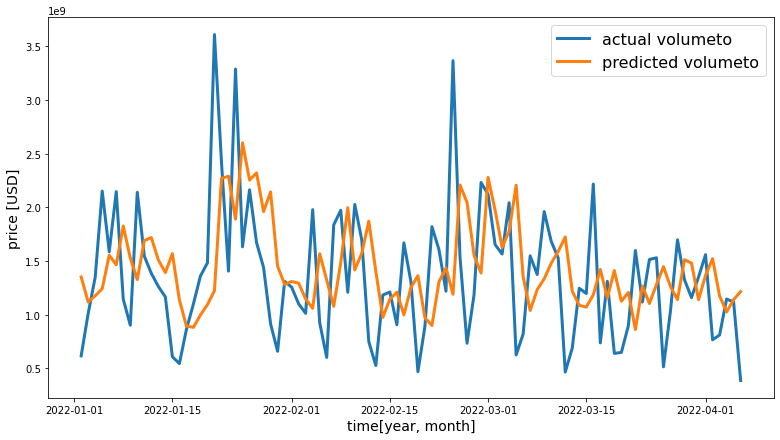

In [24]:
#test model_volumeto
preds = model_volumeto.predict(X_test_volumeto).squeeze()
targets = test_volumeto[volumeto_col][window_len:]
preds = test_volumeto[volumeto_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual volumeto', 'predicted volumeto', lw=3)

In [25]:
#sample prediction for high
test1 = test_high[-window_len:]
test1 = extract_window_data_for_prediction(test1, window_len, True)
pred = model_high.predict(test1)
mean = test_high[high_col].values[-5:].squeeze().mean()
pred1 = mean * (pred + 1)
print("Predicted high for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred1.squeeze())

#sample prediction for low
test1 = test_low[-window_len:]
test1 = extract_window_data_for_prediction(test1, window_len, True)
pred = model_low.predict(test1)
mean = test_low[low_col].values[-5:].squeeze().mean()
pred2 = mean * (pred + 1)
print("Predicted close price for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred2.squeeze())

#sample prediction for open
test1 = test_open[-window_len:]
test1 = extract_window_data_for_prediction(test1, window_len, True)
pred = model_open.predict(test1)
mean = test_open[open_col].values[-5:].squeeze().mean()
pred3 = mean * (pred + 1)
print("Predicted close price for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred3.squeeze())

#sample prediction for volumefrom
test1 = test_volumefrom[-window_len:]
test1 = extract_window_data_for_prediction(test1, window_len, True)
pred = model_volumefrom.predict(test1)
mean = test_volumefrom[volumefrom_col].values[-5:].squeeze().mean()
pred4 = mean * (pred + 1)
print("Predicted volumefrom for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred4.squeeze())

#sample prediction for volumeto
test1 = test_volumeto[-window_len:]
test1 = extract_window_data_for_prediction(test1, window_len, True)
pred = model_volumeto.predict(test1)
mean = test_volumeto[volumeto_col].values[-5:].squeeze().mean()
pred5 = mean * (pred + 1)
print("Predicted volumeto for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred5.squeeze())

#sample prediction for close price
test1 = test_close[-window_len:]
test1 = extract_window_data_for_prediction(test1, window_len, True)
pred = model_close.predict(test1)
mean = test_close[close_col].values[-5:].squeeze().mean()
pred6 = mean * (pred + 1)
print("Predicted close price for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred6.squeeze())

Predicted high for 2022-04-07 00:00:00 is: 46542.59
Predicted close price for 2022-04-07 00:00:00 is: 44805.074
Predicted close price for 2022-04-07 00:00:00 is: 45439.684
Predicted volumefrom for 2022-04-07 00:00:00 is: 19359.24
Predicted volumeto for 2022-04-07 00:00:00 is: 847691000.0
Predicted close price for 2022-04-07 00:00:00 is: 45407.785


In [26]:
#[hist.index[-1]+pd.Timedelta(days = 1),pred1[0][0],pred2[0][0],pred3[0][0],pred4[0][0],pred5[0][0],pred6[0][0]]
d = np.array(hist)

In [27]:
new_day = hist.index[-1]+pd.Timedelta(days = 1)
df_new = pd.DataFrame([[new_day,pred1[0][0],pred2[0][0],pred3[0][0],pred4[0][0],pred5[0][0],pred6[0][0]]],columns= ['time','high','low','open','volumefrom','volumeto','close'])
df_new = df_new.set_index('time')

hist = hist.append(df_new)

In [28]:
hist.tail(4)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-04-04,46893.710000,45136.030000,46414.260000,24886.340000,1.145480e+09,46609.360000
2022-04-05,47187.660000,45382.830000,46609.360000,24206.200000,1.118296e+09,45501.580000
2022-04-06,45515.590000,44465.220000,45501.580000,8551.340000,3.858807e+08,45432.230000
2022-04-07,46542.589844,44805.074219,45439.683594,19359.240234,8.476910e+08,45407.785156


In [29]:
days = 4
days_count = 0
results = []
while days_count < days:
    #prediction for high
    test1 = test_high[-window_len:]
    test1 = extract_window_data_for_prediction(test1, window_len, True)
    pred = model_high.predict(test1)
    mean = test_high[high_col].values[-5:].squeeze().mean()
    pred1 = mean * (pred + 1)
    print("Predicted high for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred1.squeeze())

    #prediction for low
    test1 = test_low[-window_len:]
    test1 = extract_window_data_for_prediction(test1, window_len, True)
    pred = model_low.predict(test1)
    mean = test_low[low_col].values[-5:].squeeze().mean()
    pred2 = mean * (pred + 1)
    print("Predicted close price for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred2.squeeze())

    #prediction for open
    test1 = test_open[-window_len:]
    test1 = extract_window_data_for_prediction(test1, window_len, True)
    pred = model_open.predict(test1)
    mean = test_open[open_col].values[-5:].squeeze().mean()
    pred3 = mean * (pred + 1)
    print("Predicted close price for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred3.squeeze())

    #prediction for volumefrom
    test1 = test_volumefrom[-window_len:]
    test1 = extract_window_data_for_prediction(test1, window_len, True)
    pred = model_volumefrom.predict(test1)
    mean = test_volumefrom[volumefrom_col].values[-5:].squeeze().mean()
    pred4 = mean * (pred + 1)
    print("Predicted volumefrom for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred4.squeeze())

    #prediction for volumeto
    test1 = test_volumeto[-window_len:]
    test1 = extract_window_data_for_prediction(test1, window_len, True)
    pred = model_volumeto.predict(test1)
    mean = test_volumeto[volumeto_col].values[-5:].squeeze().mean()
    pred5 = mean * (pred + 1)
    print("Predicted volumeto for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred5.squeeze())

    #prediction for close price
    test1 = test_close[-window_len:]
    test1 = extract_window_data_for_prediction(test1, window_len, True)
    pred = model_close.predict(test1)
    mean = test_close[close_col].values[-5:].squeeze().mean()
    pred6 = mean * (pred + 1)
    print("Predicted close price for", hist.index[-1]+pd.Timedelta(days = 1),"is:",pred6.squeeze())

    results.append(pred6)

    #extend data frame with these predictions

    new_day = hist.index[-1]+pd.Timedelta(days = 1)
    df_new = pd.DataFrame([[new_day,pred1[0][0],pred2[0][0],pred3[0][0],pred4[0][0],pred5[0][0],pred6[0][0]]],columns= ['time','high','low','open','volumefrom','volumeto','close'])
    df_new = df_new.set_index('time')
    hist = hist.append(df_new)
    #get_data
    train_high, test_high, X_train_high, X_test_high, Y_train_high, Y_test_high = prepare_data(
        hist, high_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
    train_low, test_low, X_train_low, X_test_low, Y_train_low, Y_test_low = prepare_data(
        hist, low_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
    train_open, test_open, X_train_open, X_test_open, Y_train_open, Y_test_open = prepare_data(
        hist, open_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
    train_volumefrom, test_volumefrom, X_train_volumefrom, X_test_volumefrom, Y_train_volumefrom, Y_test_volumefrom = prepare_data(
        hist, volumefrom_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
    train_volumeto, test_volumeto, X_train_volumeto, X_test_volumeto, Y_train_volumeto, Y_test_volumeto = prepare_data(
        hist, volumeto_col, window_len=window_len, zero_base=zero_base, test_size=test_size)
    train_close, test_close, X_train_close, X_test_close, Y_train_close, Y_test_close = prepare_data(
        hist, close_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

    days_count += 1

print(results)

Predicted high for 2022-04-08 00:00:00 is: 46542.59
Predicted close price for 2022-04-08 00:00:00 is: 44805.074
Predicted close price for 2022-04-08 00:00:00 is: 45439.684
Predicted volumefrom for 2022-04-08 00:00:00 is: 19359.24
Predicted volumeto for 2022-04-08 00:00:00 is: 847691000.0
Predicted close price for 2022-04-08 00:00:00 is: 45407.785
Predicted high for 2022-04-09 00:00:00 is: 45284.625
Predicted close price for 2022-04-09 00:00:00 is: 44415.227
Predicted close price for 2022-04-09 00:00:00 is: 44948.117
Predicted volumefrom for 2022-04-09 00:00:00 is: 15557.091
Predicted volumeto for 2022-04-09 00:00:00 is: 683756860.0
Predicted close price for 2022-04-09 00:00:00 is: 44734.78
Predicted high for 2022-04-10 00:00:00 is: 44723.49
Predicted close price for 2022-04-10 00:00:00 is: 44309.594
Predicted close price for 2022-04-10 00:00:00 is: 44230.79
Predicted volumefrom for 2022-04-10 00:00:00 is: 13009.401
Predicted volumeto for 2022-04-10 00:00:00 is: 566156160.0
Predicted cl

In [30]:
(np.array(results)).squeeze()

array([45407.785, 44734.78 , 44664.312, 44390.57 ], dtype=float32)

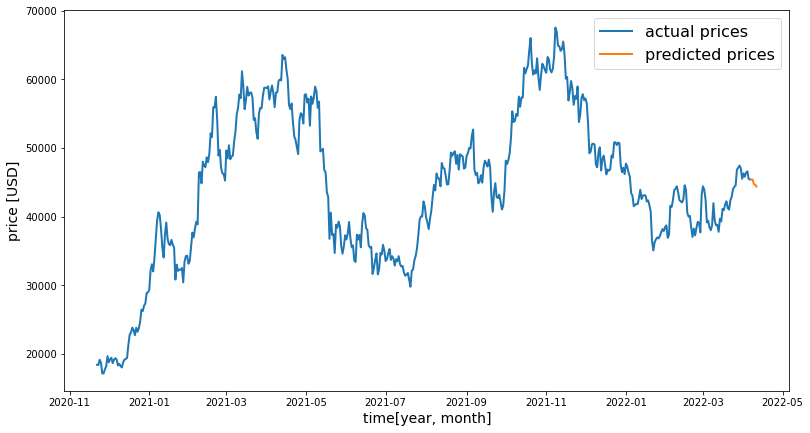

In [31]:
line_plot(hist['close'][:-5],hist['close'][-5:], label1='actual prices',label2='predicted prices')